In [1]:
from google.colab import files
uploaded = files.upload()

Saving cookie_cats.csv to cookie_cats.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
df = pd.read_csv("cookie_cats.csv")

# Encode necessary values
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)
df['version_encoded'] = df['version'].map({'gate_30': 0, 'gate_40': 1})

In [4]:
# Split groups
group_30 = df[df['version'] == 'gate_30']
group_40 = df[df['version'] == 'gate_40']

# Day 1 t-test
t1, p1 = stats.ttest_ind(group_30['retention_1'], group_40['retention_1'])
print(f"Day 1 Retention — t-stat: {t1:.4f}, p-value: {p1:.4f}")

# Day 7 t-test
t7, p7 = stats.ttest_ind(group_30['retention_7'], group_40['retention_7'])
print(f"Day 7 Retention — t-stat: {t7:.4f}, p-value: {p7:.4f}")

Day 1 Retention — t-stat: 1.7841, p-value: 0.0744
Day 7 Retention — t-stat: 3.1645, p-value: 0.0016


In [5]:
# Features + label
X = df[['sum_gamerounds', 'version_encoded']]
y = df['retention_7']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict probabilities on full dataset
df['model_pred'] = model.predict_proba(X)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [6]:
# SHAP explanation on full dataset (X)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Add SHAP values
df['shap_gamerounds'] = shap_values[:, 0]
df['shap_version'] = shap_values[:, 1]

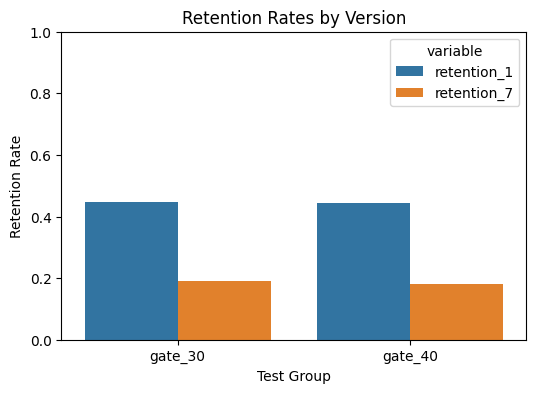

In [7]:
# Group-level retention rates
retention = df.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='version', y='value', hue='variable',
            data=pd.melt(retention, id_vars='version'))
plt.title("Retention Rates by Version")
plt.ylabel("Retention Rate")
plt.xlabel("Test Group")
plt.ylim(0, 1)
plt.show()


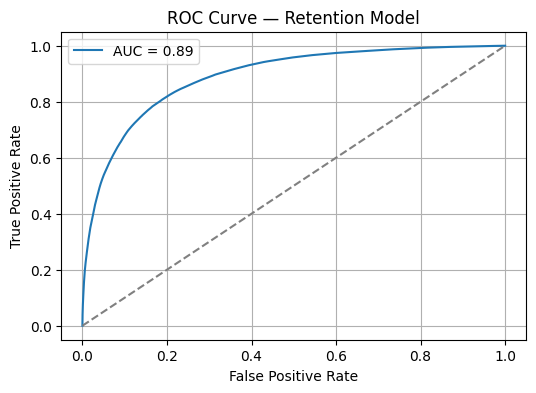

In [8]:
y_true = df['retention_7']
y_scores = df['model_pred']

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Retention Model")
plt.legend()
plt.grid(True)
plt.show()

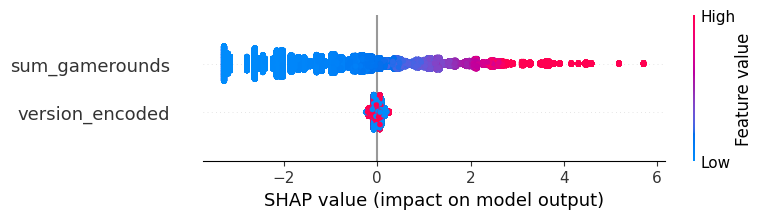

In [9]:
# Global SHAP importance plot (summary of all users)
shap.summary_plot(shap_values, X)

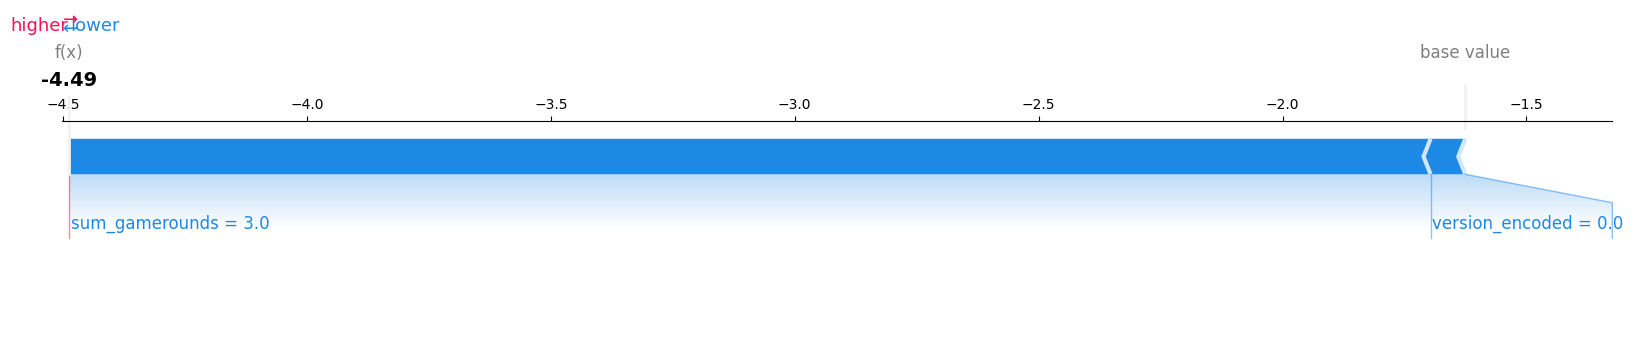

In [10]:
# Pick one test row for explanation
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X.iloc[0],
    matplotlib=True  # this works well in Colab
)

In [11]:
print("User Features:")
print(X.iloc[0])  # or any index

print("\nPredicted Probability of Retention:")
print(model.predict_proba(X.iloc[[0]])[:, 1])

User Features:
sum_gamerounds     3
version_encoded    0
Name: 0, dtype: int64

Predicted Probability of Retention:
[0.0111235]


In [14]:
import numpy as np

def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d_ret7 = cohens_d(group_30['retention_7'], group_40['retention_7'])
print(f"Cohen's d for Day 7 Retention: {d_ret7:.3f}")

Cohen's d for Day 7 Retention: 0.021


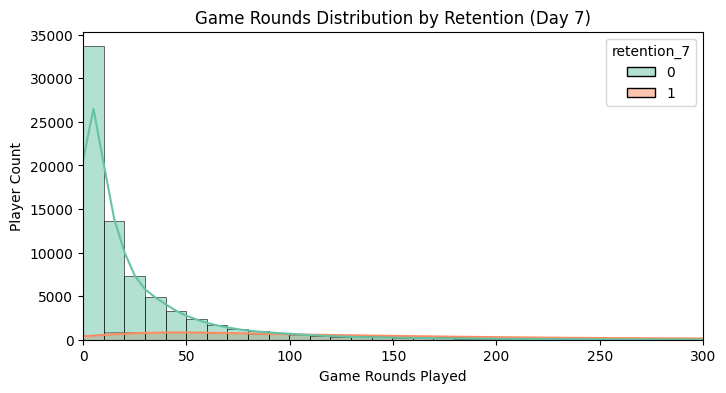

In [17]:
# Remove extreme outliers for better visualization
df_plot = df[df['sum_gamerounds'] < 1000]  # or <500 depending on spread

plt.figure(figsize=(8, 4))
sns.histplot(data=df_plot, x='sum_gamerounds', hue='retention_7', bins=100, kde=True, palette='Set2')
plt.title("Game Rounds Distribution by Retention (Day 7)")
plt.xlabel("Game Rounds Played")
plt.ylabel("Player Count")
plt.xlim(0, 300)  # tweak for clarity
plt.show()

In [19]:
# Define early engagement levels
bins = [0, 5, 10, 25, 50, 100, 250, df['sum_gamerounds'].max()]
labels = ['0–5', '6–10', '11–25', '26–50', '51–100', '101–250', '250+']
df['engagement_level'] = pd.cut(df['sum_gamerounds'], bins=bins, labels=labels, right=False)

<ipython-input-20-95a0bd6adbfd>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ret_by_bin = df.groupby('engagement_level')['retention_7'].mean().reset_index()
<ipython-input-20-95a0bd6adbfd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='engagement_level', y='retention_7', data=ret_by_bin, palette='viridis')


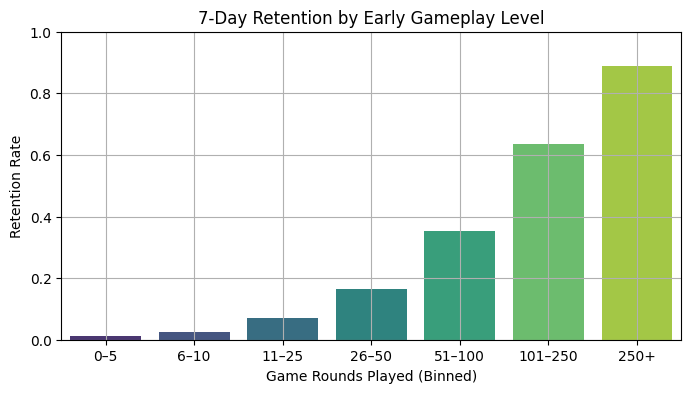

In [20]:
ret_by_bin = df.groupby('engagement_level')['retention_7'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='engagement_level', y='retention_7', data=ret_by_bin, palette='viridis')
plt.title("7-Day Retention by Early Gameplay Level")
plt.ylabel("Retention Rate")
plt.xlabel("Game Rounds Played (Binned)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [21]:
pop_counts = df['engagement_level'].value_counts().sort_index()
ret_counts = df.groupby('engagement_level')['retention_7'].sum()

ret_impact = pd.DataFrame({
    'Users': pop_counts,
    'Retained': ret_counts,
    'Retention Rate': ret_counts / pop_counts
}).reset_index()

display(ret_impact)

<ipython-input-21-d27bba211956>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ret_counts = df.groupby('engagement_level')['retention_7'].sum()


,engagement_level,Users,Retained,Retention Rate
0,0–5,21725,259,0.011922
1,6–10,12512,319,0.025496
2,11–25,19204,1337,0.069621
3,26–50,13583,2227,0.163955
4,51–100,10649,3742,0.351394
5,101–250,8793,5593,0.636074
6,250+,3722,3303,0.887426
